In [1]:
import numpy as np
import pandas as pd
from gensim.matutils import dirichlet_expectation
import os
from gensim.test.utils import datapath
import gzip
import json
from gensim import models
import ijson
import pickle
from tqdm import tqdm
from itertools import chain
import seaborn as sns
from itertools import combinations

In [2]:
inputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Inputs"
intermediate_outputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/IntermediateOutputs"
results_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Results"

<h2> Calculate alpha and  $\theta_d$ for each document! </h2>

From the model training I need

* corpus
* doc2inv
* model

* author2id - from model
* expElogbeta - from model
* gamma - from model


Save them to a txt file externally?

In [3]:
theta_ds = []
author2id = pickle.load(open(f"{intermediate_outputs_path}/inv2id.p", "rb"))
doc2inv = pickle.load(open(f"{intermediate_outputs_path}/doc2inv.p", "rb"))
expElogbeta = np.load(f"{intermediate_outputs_path}/model.expElogbeta.npy")
gamma = np.load(f"{intermediate_outputs_path}/model.state.gamma.npy")
unique_pat_dict = pickle.load(open(f"{intermediate_outputs_path}/unique_pat_dict.p", "rb"))
inv2id = pickle.load(open(f"{intermediate_outputs_path}/inv2id.p", "rb"))

In [14]:
doc_list = []
# Load corpus one doc at a time
with open(f"{intermediate_outputs_path}/corpus.json", 'rb') as input_file:
    jsonobj = ijson.items(input_file, 'item')
    jsons = (o for o in jsonobj)

    for doc_no, doc in enumerate(tqdm(jsons)):

        if doc and not isinstance(doc[0][0], (int, np.integer,)):
            # make sure the term IDs are ints, otherwise np will get upset
            ids = [int(idx) for idx, _ in doc]
        else:
            ids = [idx for idx, _ in doc]

        expElogbetad = expElogbeta[:, ids]

        expElogbetad_sumv = np.sum(expElogbetad, axis=1)
        expElogbetad_sumv = expElogbetad_sumv.reshape(1, -1)
        expElogbetad_sumv = np.repeat(expElogbetad_sumv, repeats=len(doc2inv[doc_no]), axis=0)

        authors_d = np.fromiter((author2id[a] for a in doc2inv[doc_no]), dtype=int)
        gammad = gamma[authors_d, :]

        Elogthetad = dirichlet_expectation(gammad)
        expElogthetad = np.exp(Elogthetad)

        phi_dvak_numerator = expElogthetad * expElogbetad_sumv
        phi_dak = phi_dvak_numerator / np.sum(phi_dvak_numerator, keepdims=True)
         
        theta_ds.append(np.sum(phi_dak, axis=0))
        
        doc_data = pd.DataFrame({'doc_id': [doc_no]*len(np.sum(phi_dak, axis=1)),
                                 'inventor_number': np.fromiter((author2id[a] for a in doc2inv[doc_no]), dtype=int),
                                 'alpha_i': np.sum(phi_dak, axis=1)
                                 }) # Might have to add an index here 
        
        doc_list.append(doc_data) # Check the memory use.

# Intermediate save    
document_data = pd.concat(doc_list, axis=0)
document_data.to_csv(f"{results_path}/document_data.csv", index=False)      

15544it [00:55, 297.74it/s]C:\Users\Hannes\AppData\Local\Temp/ipykernel_6200/3883087887.py:28: RuntimeWarning: invalid value encountered in true_divide
  phi_dak = phi_dvak_numerator / np.sum(phi_dvak_numerator, keepdims=True)
876535it [53:08, 274.94it/s]


In [15]:
id2inv = {id:inv for inv, id in inv2id.items()}

In [16]:
document_data["patent_number"] = document_data["doc_id"].map(unique_pat_dict)
document_data["inventor_id"] = document_data["inventor_number"].map(id2inv)
document_data

,doc_id,inventor_number,alpha_i,patent_number,inventor_id
0,0,455309,1.000000,5077839,fl:st_ln:keller-13
0,1,97228,0.255909,5077870,fl:da_ln:bychinski-1
1,1,295597,0.150625,5077870,fl:le_ln:wood-3
2,1,314490,0.211713,5077870,fl:ma_ln:lindseth-1
3,1,464950,0.223438,5077870,fl:su_ln:nestegard-1
...,...,...,...,...,...
0,876533,125909,0.398979,8341754,fl:di_ln:weir-2
1,876533,424426,0.601021,8341754,fl:ro_ln:weir-4
0,876534,272533,0.323986,8341759,fl:ke_ln:gross-8
1,876534,36982,0.319075,8341759,fl:an_ln:lewis-6


Add in a team identifer and calulcate relevant statistics - later on simply merge in external data sources 

In [17]:
teams = document_data.groupby('patent_number')['inventor_id'].agg(frozenset)
teams = pd.DataFrame(teams)
teams.reset_index(inplace=True)
teams["team_id"] = teams.groupby("inventor_id").ngroup()
teams_counter = document_data.groupby('patent_number')['inventor_id'].agg(frozenset).value_counts()

teams_counter = pd.DataFrame(teams_counter)
teams_counter.reset_index(inplace=True)

team_dict = teams[["patent_number", "team_id"]]
team_dict = team_dict.drop_duplicates()
team_dict = dict(zip(team_dict["patent_number"], team_dict["team_id"]))
document_data["team_id"] = document_data["patent_number"].map(team_dict)

In [19]:
num_topics = 20
center = np.array([1/num_topics]*num_topics)
theta_docs = np.vstack(theta_ds)
theta_docs = pd.DataFrame(theta_docs)
theta_docs.reset_index(inplace=True)
theta_docs.rename(columns={"index":"patent_unique"}, inplace=True)
theta_docs["patent_number"] = theta_docs["patent_unique"].map(unique_pat_dict)
theta_docs["patent_number"] = theta_docs["patent_number"].astype(str)
theta_docs.drop(columns="patent_unique", inplace=True)
theta_docs.set_index("patent_number", inplace=True)
theta_docs["distance"] = theta_docs.apply(lambda x: np.linalg.norm(x-center), axis=1)
theta_docs.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,distance
patent_number,,,,,,,,,,,,,,,,,,,,,
5077839,0.026384,0.005217,0.003750,6.895594e-07,0.117551,0.149969,0.000001,0.139802,0.089219,0.006353,...,0.000002,0.006999,0.005427,0.000425,0.011225,0.003679,0.117077,9.125594e-07,0.099881,0.292571
5077870,0.167586,0.011450,0.029825,2.350819e-02,0.002674,0.000007,0.003306,0.385183,0.080908,0.000411,...,0.011046,0.087311,0.022295,0.058095,0.012224,0.001894,0.049973,1.185411e-02,0.005653,0.387607
5077875,0.019264,0.000002,0.007516,1.399580e-04,0.022918,0.112307,0.070633,0.019968,0.281372,0.003269,...,0.001215,0.000004,0.000784,0.129310,0.002000,0.001780,0.155310,6.459148e-04,0.020145,0.335140
5077878,0.028872,0.000962,0.001958,8.712228e-03,0.160267,0.097009,0.070911,0.049050,0.062878,0.000003,...,0.132697,0.027399,0.008840,0.009650,0.033965,0.011449,0.147602,1.046634e-01,0.010790,0.226087
5077893,0.096106,0.026689,0.048461,1.084483e-02,0.005867,0.133618,0.011689,0.005946,0.346555,0.031391,...,0.017732,0.004693,0.000337,0.002766,0.020589,0.033889,0.015834,2.927602e-03,0.011778,0.365457


<AxesSubplot:xlabel='distance', ylabel='Count'>

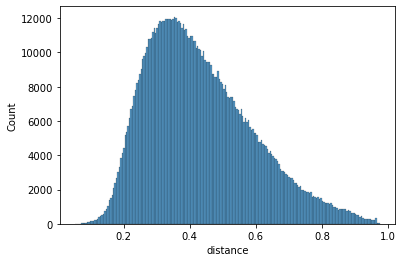

In [20]:
sns.histplot(theta_docs["distance"])

In [21]:
patent_distance = theta_docs[["distance"]]
patent_distance = dict(zip(patent_distance.index, patent_distance["distance"]))
document_data["patent_number"] = document_data["patent_number"].astype(str)
document_data["patent_distance"] = document_data["patent_number"].map(patent_distance)

In [ ]:
#document_data.to_csv(f"{results_path}/document_data.csv", index=False)

In [22]:
teams.head() #Build teamsize count...

,patent_number,inventor_id,team_id
0,5077839,(fl:st_ln:keller-13),0
1,5077870,"(fl:ma_ln:lindseth-1, fl:da_ln:bychinski-1, fl...",360041
2,5077875,"(fl:ja_ln:carter-54, fl:no_ln:pan-1, fl:wi_ln:...",360040
3,5077878,"(fl:ma_ln:stern-9, fl:ma_ln:tabasky-1, fl:ch_l...",360039
4,5077893,"(fl:re_ln:mosquera-1, fl:ji_ln:powell-5)",360038


<AxesSubplot:xlabel='team_size', ylabel='Count'>

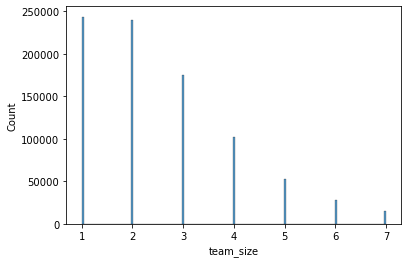

In [23]:
teams["team_size"] = teams["inventor_id"].apply(lambda x: len(x))
team_size_dict = dict(zip(teams["team_id"], teams["team_size"]))
document_data["team_size"] = document_data["team_id"].map(team_size_dict)
sns.histplot(teams[teams["team_size"]<8]["team_size"])

In [24]:
distributions = pd.read_csv(f"{results_path}/inventor_distributions.csv")
distributions.set_index("inventor_id", inplace=True)
distributions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
inventor_id,,,,,,,,,,,,,,,,,,,,
000f0k6brgval6kr9agzjlgcg,0.064537,0.028634,0.018825,0.019273,0.049114,0.021086,0.017793,0.016962,0.015963,0.021822,0.031646,0.227510,0.013055,0.023864,0.016004,0.032771,0.018583,0.300064,0.016572,0.045921
000s9qy0x4l3x4n99bv2a1qn4,0.036235,0.029636,0.038960,0.035015,0.036463,0.046972,0.030500,0.039450,0.080068,0.103947,0.029732,0.040881,0.031187,0.086560,0.033716,0.047335,0.106933,0.043066,0.032691,0.070653
003gl0pmpob62w5yf9j8xw1c8,0.052592,0.017268,0.014634,0.014272,0.018287,0.020108,0.178831,0.000000,0.013428,0.169293,0.025588,0.170891,0.018351,0.032492,0.012810,0.014909,0.012661,0.175302,0.019602,0.018679
003ibk308p0r5efhppfnkpghy,0.035597,0.042729,0.067434,0.135890,0.049154,0.032987,0.035689,0.027072,0.031900,0.036260,0.029895,0.033401,0.028006,0.039150,0.027994,0.057273,0.040069,0.037598,0.173078,0.038823
004sxraydhup13ce43vyj61p1,0.044167,0.013710,0.016535,0.712317,0.011090,0.000000,0.013478,0.000000,0.000000,0.013224,0.012292,0.047486,0.000000,0.011032,0.000000,0.011988,0.000000,0.033351,0.011965,0.047366


In [25]:
inventor_distance_center_dict = dict.fromkeys(distributions.index)
center = np.array([1/num_topics]*num_topics)
for inv in tqdm(distributions.index):
    d_center = np.linalg.norm(distributions.loc[inv] - center)
    inventor_distance_center_dict[inv] = d_center
document_data["inventor_distance"] = document_data["inventor_id"].map(inventor_distance_center_dict)

100%|████████████████████████████████████████████████████████████████████████| 549961/549961 [01:01<00:00, 8876.49it/s]


In [26]:
D_team_dict = dict.fromkeys(document_data["team_id"])

for patent_id, team_df in tqdm(document_data.groupby("team_id")):

    if team_df["inventor_distance"].isnull().values.any():

        D_team_dict[team_id] = np.nan

    else:

        team_id = team_df.iloc[0]["team_id"]

        inventor_combos = list(combinations(np.unique(team_df["inventor_id"]), 2))
        team_distances = []
        for (inv1, inv2) in inventor_combos:
            d = np.linalg.norm(distributions.loc[inv1] - distributions.loc[inv2])
            team_distances.append(d)

        D_team_dict[team_id] = np.mean(team_distances)

document_data["D_team"] = document_data["team_id"].map(D_team_dict)

  0%|                                                                                       | 0/540054 [00:00<?, ?it/s]C:\Users\Hannes\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Hannes\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████| 540054/540054 [08:45<00:00, 1027.58it/s]


In [30]:
document_data.head()

,doc_id,inventor_number,alpha_i,patent_number,inventor_id,team_id,patent_distance,team_size,inventor_distance,D_team,D_team_alpha
0,0,455309,1.000000,5077839,fl:st_ln:keller-13,0,0.292571,1,0.321519,NaN,NaN
0,1,97228,0.255909,5077870,fl:da_ln:bychinski-1,360041,0.387607,5,0.415432,0.359408,0.076443
1,1,295597,0.150625,5077870,fl:le_ln:wood-3,360041,0.387607,5,0.465787,0.359408,0.076443
2,1,314490,0.211713,5077870,fl:ma_ln:lindseth-1,360041,0.387607,5,0.339747,0.359408,0.076443
3,1,464950,0.223438,5077870,fl:su_ln:nestegard-1,360041,0.387607,5,0.305534,0.359408,0.076443


In [28]:
D_team_dict = dict.fromkeys(document_data["team_id"])
alpha_dict = dict(zip(document_data["inventor_id"], document_data["alpha_i"]))


for team_id, team_df in tqdm(document_data.groupby("team_id")):

    if team_df["inventor_distance"].isnull().values.any():

        D_team_dict[team_id] = np.nan

    else:

        team_id = team_df.iloc[0]["team_id"]
        team_size = team_df.iloc[0]["team_size"]

        inventor_combos = list(combinations(np.unique(team_df["inventor_id"]), 2))
        team_distances = []
        for (inv1, inv2) in inventor_combos:
            alpha_1 = alpha_dict[inv1]
            alpha_2 = alpha_dict[inv2]

            d = np.linalg.norm(distributions.loc[inv1] - distributions.loc[inv2]) * alpha_1 * alpha_2 * team_size
            team_distances.append(d)

        D_team_dict[team_id] = np.mean(team_distances)

document_data["D_team_alpha"] = document_data["team_id"].map(D_team_dict)

  0%|                                                                                       | 0/540054 [00:00<?, ?it/s]C:\Users\Hannes\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Hannes\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████| 540054/540054 [09:37<00:00, 934.74it/s]


In [29]:
document_data.head() # Check the distance names are identifiable

,doc_id,inventor_number,alpha_i,patent_number,inventor_id,team_id,patent_distance,team_size,inventor_distance,D_team,D_team_alpha
0,0,455309,1.000000,5077839,fl:st_ln:keller-13,0,0.292571,1,0.321519,NaN,NaN
0,1,97228,0.255909,5077870,fl:da_ln:bychinski-1,360041,0.387607,5,0.415432,0.359408,0.076443
1,1,295597,0.150625,5077870,fl:le_ln:wood-3,360041,0.387607,5,0.465787,0.359408,0.076443
2,1,314490,0.211713,5077870,fl:ma_ln:lindseth-1,360041,0.387607,5,0.339747,0.359408,0.076443
3,1,464950,0.223438,5077870,fl:su_ln:nestegard-1,360041,0.387607,5,0.305534,0.359408,0.076443


In [32]:
document_data.to_csv(f"{results_path}/document_data.csv", index=False)